# Raman taxonomy

## Load and clean data

Load packages, etc.

In [3]:
suppressPackageStartupMessages(library(reticulate))
suppressPackageStartupMessages(library(umap))
suppressPackageStartupMessages(library(gplots))
suppressPackageStartupMessages(library(plotrix))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(lsa))
suppressPackageStartupMessages(library(ape))
suppressPackageStartupMessages(library(phytools))
suppressPackageStartupMessages(library(phylosignal))
suppressPackageStartupMessages(library(scales))

setwd('/Users/ryanyork/Documents/Research/github/raman-taxonomy/')
suppressPackageStartupMessages(source('01_utils/R/arcadia.pal.R'))
suppressPackageStartupMessages(source('01_utils/R/darken_color.R'))
np <- import("numpy")

Load spectral data and config script (contains strain name info etc.)

In [6]:
#Load Ho et al. 2019 data
x = np$load('00_data/ho_et_al_2019/X_finetune.npy')
y = np$load('00_data/ho_et_al_2019/y_finetune.npy')

#Load config (contains strain name info, etc.)
config = source_python('00_data/ho_et_al_2019/config.py')

#Get names by ordering strains (have to +1 order since its 0 indexed as in python; R wants to start with 1)
n = unlist(STRAINS)

#Load taxonomic groups
taxa = read.csv('00_data/ho_et_al_2019/taxonomic_groups.csv')

Calculate mean spectra for each strain

In [7]:
m = lapply(split(as.data.frame(x), y), function(z) colMeans(z))
m = do.call(rbind, m)
rownames(m) = n

Calculate standard error for each strain's spectrum

In [8]:
se = lapply(split(as.data.frame(x), y), function(z){
  apply(z, 2, function(w) plotrix::std.error(w))
})
se = do.call(rbind, se)
rownames(se) = n

## Plot spectra

Generate taxonomic matrix that matches length of sample matrix

In [9]:
pred = as.data.frame(cbind(apply(taxa, 2, function(x) rep(x, each = 100))))

Set up colors (coloring by genera)

In [10]:
cols = c(arcadia.pal(n = 6, name = 'Accent'), arcadia.pal(n = 6, name = 'Lighter_accents'))[1:length(unique(taxa$Genus))]
names(cols) = unique(taxa$Genus)
cols = cols[match(taxa$Genus, names(cols))]

Plot spectra and overlay mean spectrum

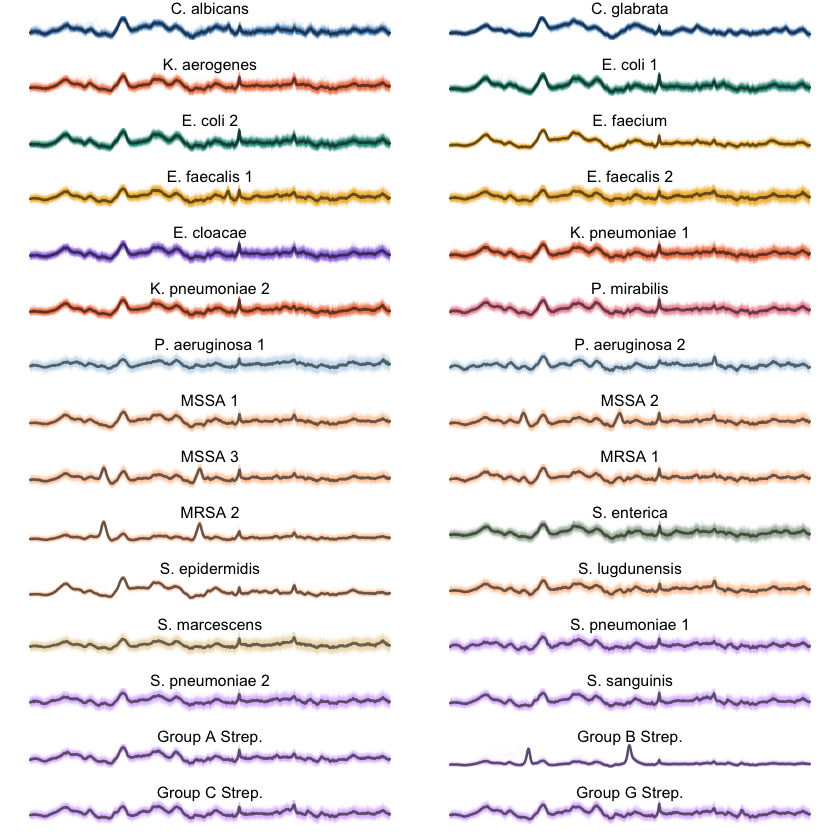

In [11]:
#Set up plot
par(mfrow = c(15,2), mar = c(1,1,1,1))

#Loop through and plot
for(i in 1:length(unique(pred$Strain))){
  
  #Extract spectra
  tmp = x[grep(unique(pred$Strain)[i], pred$Strain),]
  
  #Initiate plot
  plot(tmp[1,], col = alpha(cols[i], 0.05), type = 'l', bty = 'n', xaxt = 'n', yaxt = 'n', xlab = '', ylab = '')
  
  #Add lines
  for(j in 2:nrow(tmp)){
    lines(tmp[j,], col = alpha(cols[i], 0.05))
  }
  
  #Add mean
  lines(m[i,], lwd = 2, col = darken_color(cols[i], factor = 2))
  
  #Add label
  title(main = unique(pred$Strain)[i], font.main = 1)
  
}

## Compare spectra using cosine similarity

Calculate all-by-all cosine similarity

In [12]:
d = lsa::cosine(t(x))

Plot the distribution

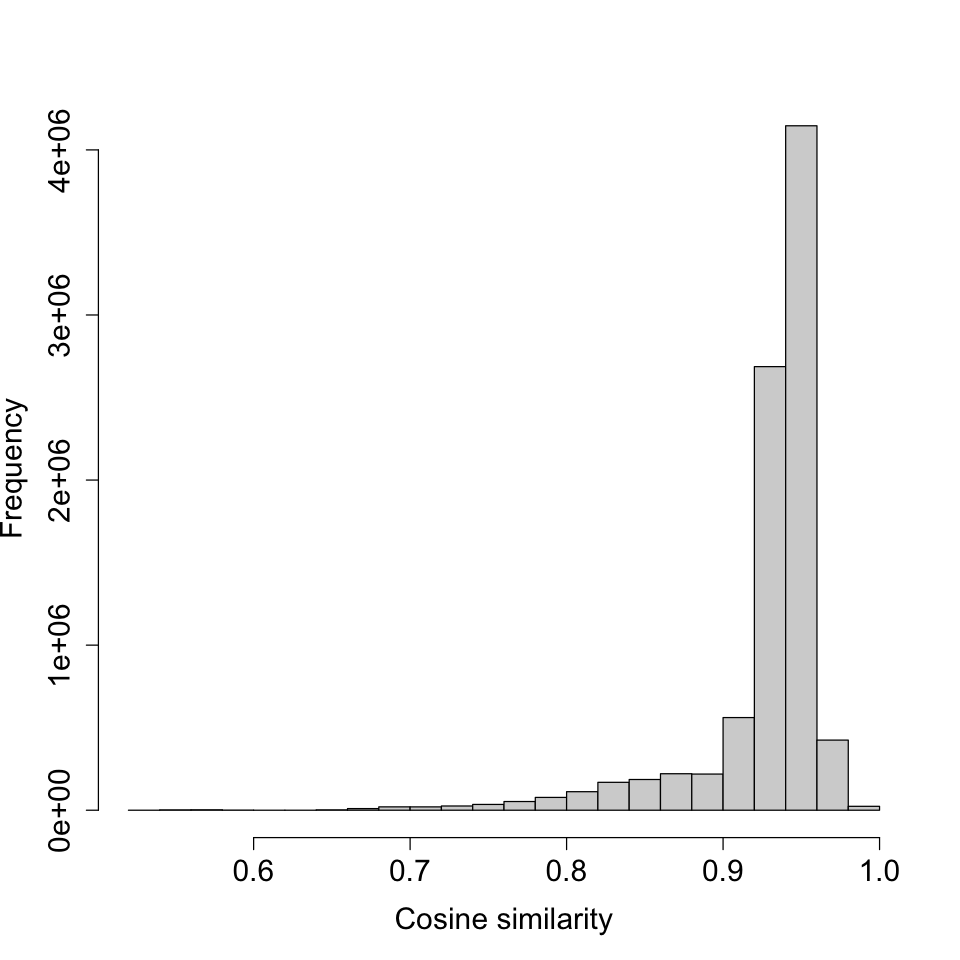

In [17]:
options(repr.plot.width=8, repr.plot.height=8)
hist(unlist(as.data.frame(d)), cex.axis = 1.5, cex.lab = 1.5, main = '', xlab = 'Cosine similarity')

Bin cosine similarities by taxonomic units

In [14]:
res = list()
for(i in 1:(ncol(pred)-1)){
  
  tmp = split(as.data.frame(d), pred[,i])
  for(j in 1:length(tmp)){
    tmp[[j]] = tmp[[j]][,pred[,i]%in%names(tmp)[j]]
    tmp[[j]] = tmp[[j]][!tmp[[j]] == 1]
    tmp[[j]] = mean(tmp[[j]])
  }
  res[[colnames(pred)[i]]] = unlist(tmp)
}

Plot the distributions

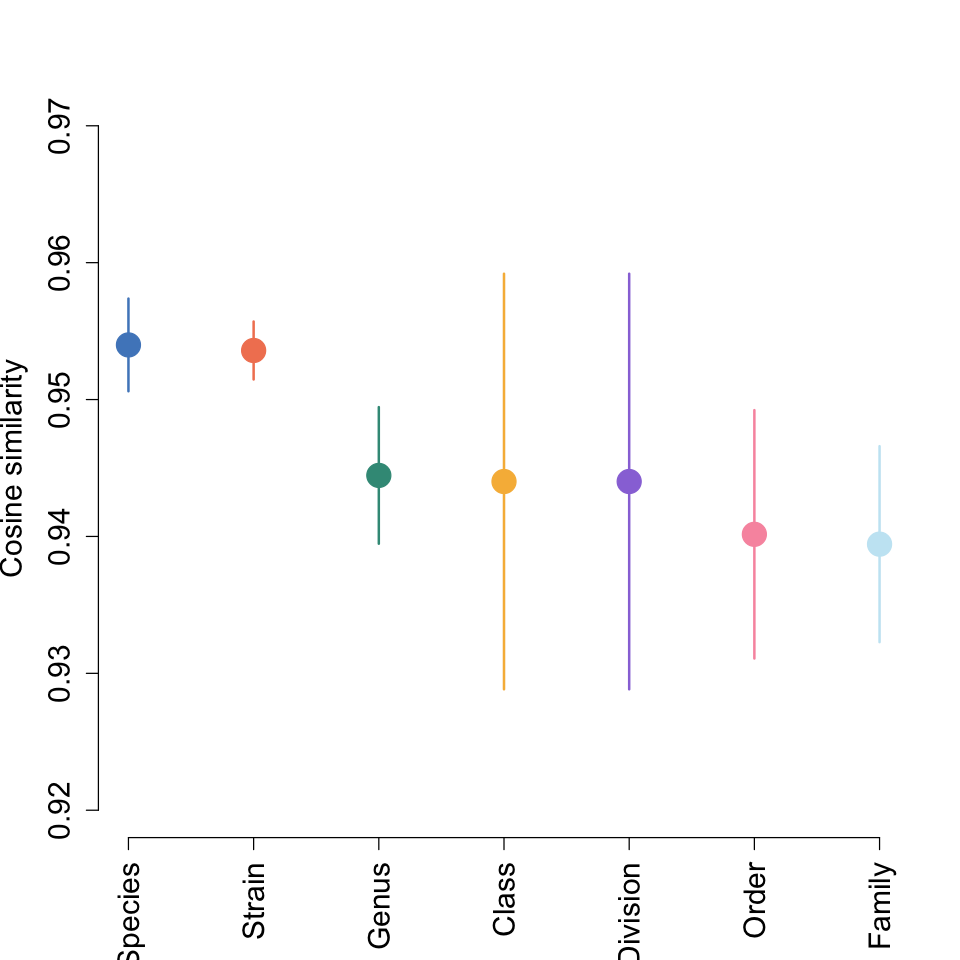

In [28]:
options(repr.plot.width=8, repr.plot.height=8)

m1 = unlist(lapply(res, function(y) mean(y)))
se1 = unlist(lapply(res, function(y) plotrix::std.error(y)))

o = order(m1, decreasing = TRUE)
cols = c(arcadia.pal(n = 6, name = 'Accent'), arcadia.pal(n = 6, name = 'Lighter_accents'))[1:length(m1)]
plot(m1[o],
     pch = 20,
     cex = 4,
     col = cols,
     ylim = c(0.92, 0.97),
     ylab = 'Cosine similarity',
     xlab = '',
     cex.lab = 1.5,
     cex.axis = 1.5,
     xaxt = 'n',
     bty = 'n')
axis(1, 1:length(m1), names(m1)[o], cex.axis = 1.5, las = 2)
for(i in 1:length(se1)){
  segments(i, m1[o][i]-se1[o][i], i, m1[o][i]+se1[o][i], col = cols[i], lwd = 2)
}

## Compare spectra using linear models

Run PCA on spectra

In [20]:
pca = prcomp(x)

Generate taxonomic matrix that matches length of sample matrix

In [21]:
pred = as.data.frame(cbind(apply(taxa, 2, function(x) rep(x, each = 100))))

#Add outcome column
pred$out = pca$x[,1]

Calculate linear models using taxonomic units as predictors

In [22]:
mods = list()
for(i in 1:(ncol(pred)-1)){
  mods[[colnames(pred)[i]]] = lm(pred$out~pred[,i])
}

Add model using all taxonomic units as predictors

In [23]:
mods[['All']] = lm(out~., data = pred)

Calculate BIC

In [24]:
bics = lapply(mods, function(x) BIC(x))

Plot

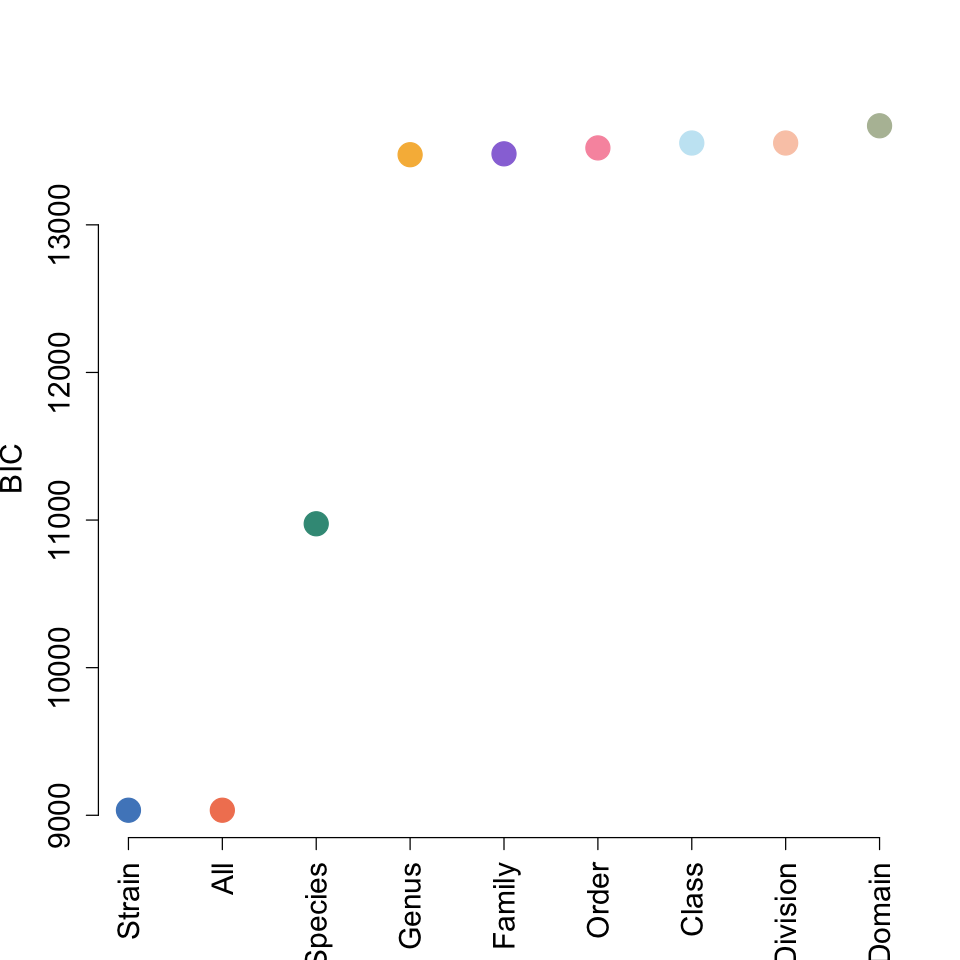

In [29]:
options(repr.plot.width=8, repr.plot.height=8)

bics = sort(unlist(bics))

o = order(bics)
cols = c(arcadia.pal(n = 6, name = 'Accent'), arcadia.pal(n = 6, name = 'Lighter_accents'))[1:length(bics)]
plot(bics[o],
     pch = 20,
     cex = 4,
     col = cols,
     ylab = 'BIC',
     xlab = '',
     cex.lab = 1.5,
     cex.axis = 1.5,
     xaxt = 'n',
     bty = 'n')
axis(1, 1:length(bics), names(bics)[o], cex.axis = 1.5, las = 2)

## Phylogenetic comparisons

Load phylogeny

In [30]:
phylo = read.newick('00_data/ho_et_al_2019/ho_2019_species_list_for_timetree.nwk')

Plot phylogeny

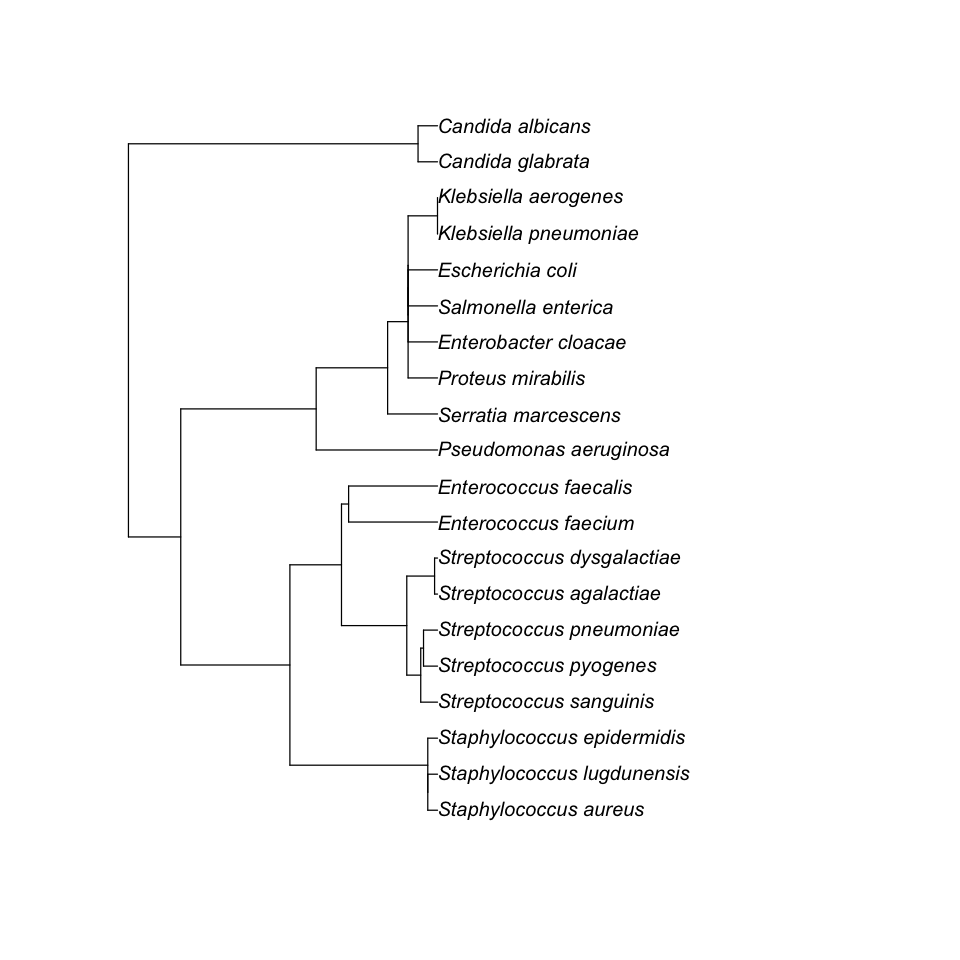

In [35]:
options(repr.plot.width=8, repr.plot.height=8)

plot(phylo)

Calculate species-level mean spectra

In [31]:
#Generate matrix for calculate means by species
m2 = m
rownames(m2) = paste(taxa$Genus, taxa$Species, sep = '_')

#Split by species
m2 = split(as.data.frame(m2), rownames(m2))

#Calculate mean by species
m2 = lapply(m2, function(x) colMeans(x))

#Recombine
m2 = do.call(rbind, m2)

Generate phylogeny from mean spectra

In [32]:
spectra = as.phylo(nj(dist(m2)))

Plot

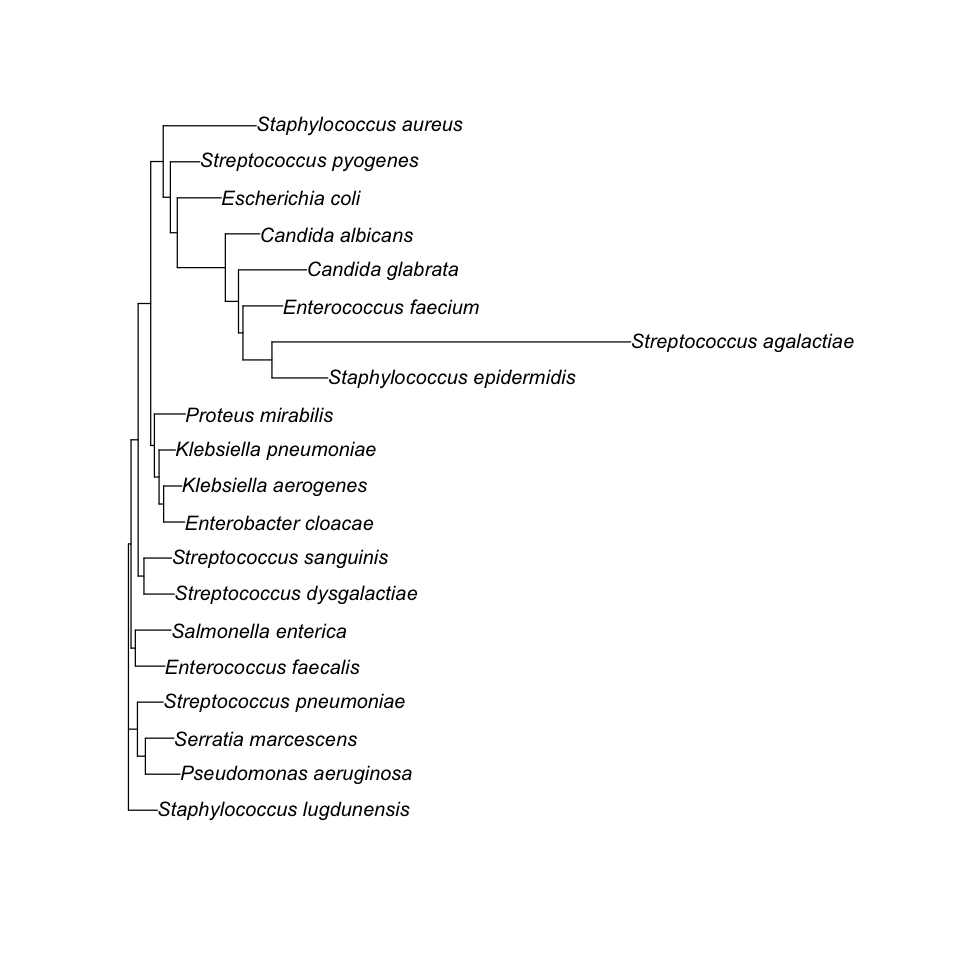

In [36]:
options(repr.plot.width=8, repr.plot.height=8)

plot(spectra)

Cophyloplot comparing phylogeny and spectra

Rotating nodes to optimize matching...
Done.


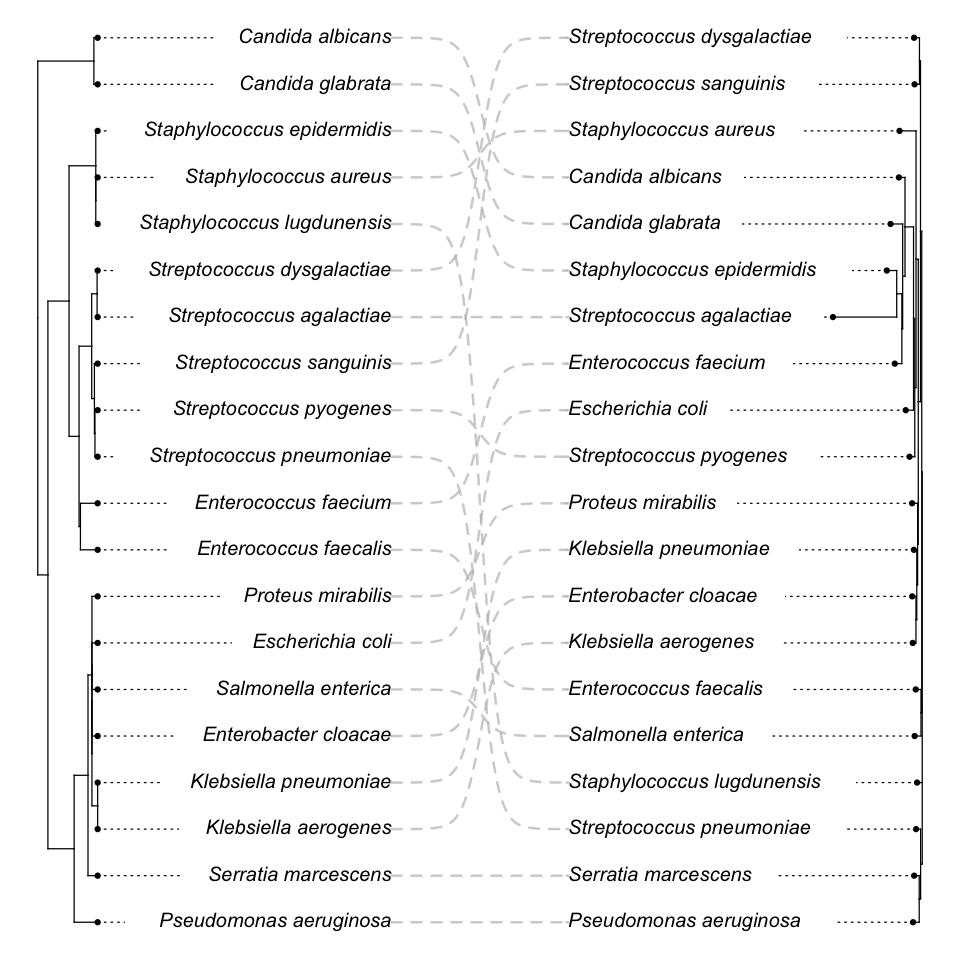

In [37]:
options(repr.plot.width=8, repr.plot.height=8)

obj = cophylo(phylo, spectra)
plot(obj,
     link.type="curved",
     link.lwd=2,
     link.col=make.transparent("grey",0.7))

PCA on species mean spectra

In [38]:
pca = prcomp(m2)

Calculate phylogenetic signal of PCs and spectra

In [39]:
#Phylogenetic signal of PCs
phylosig_pcs = apply(pca$x[match(phylo$tip.label, rownames(pca$x)),], 2, function(x) phylosig(phylo, x))

#Phylogenetic signal of spectra
phylosig_spectra = apply(m2[match(phylo$tip.label, rownames(m2)),], 2, function(x) phylosig(phylo, x))

Plot

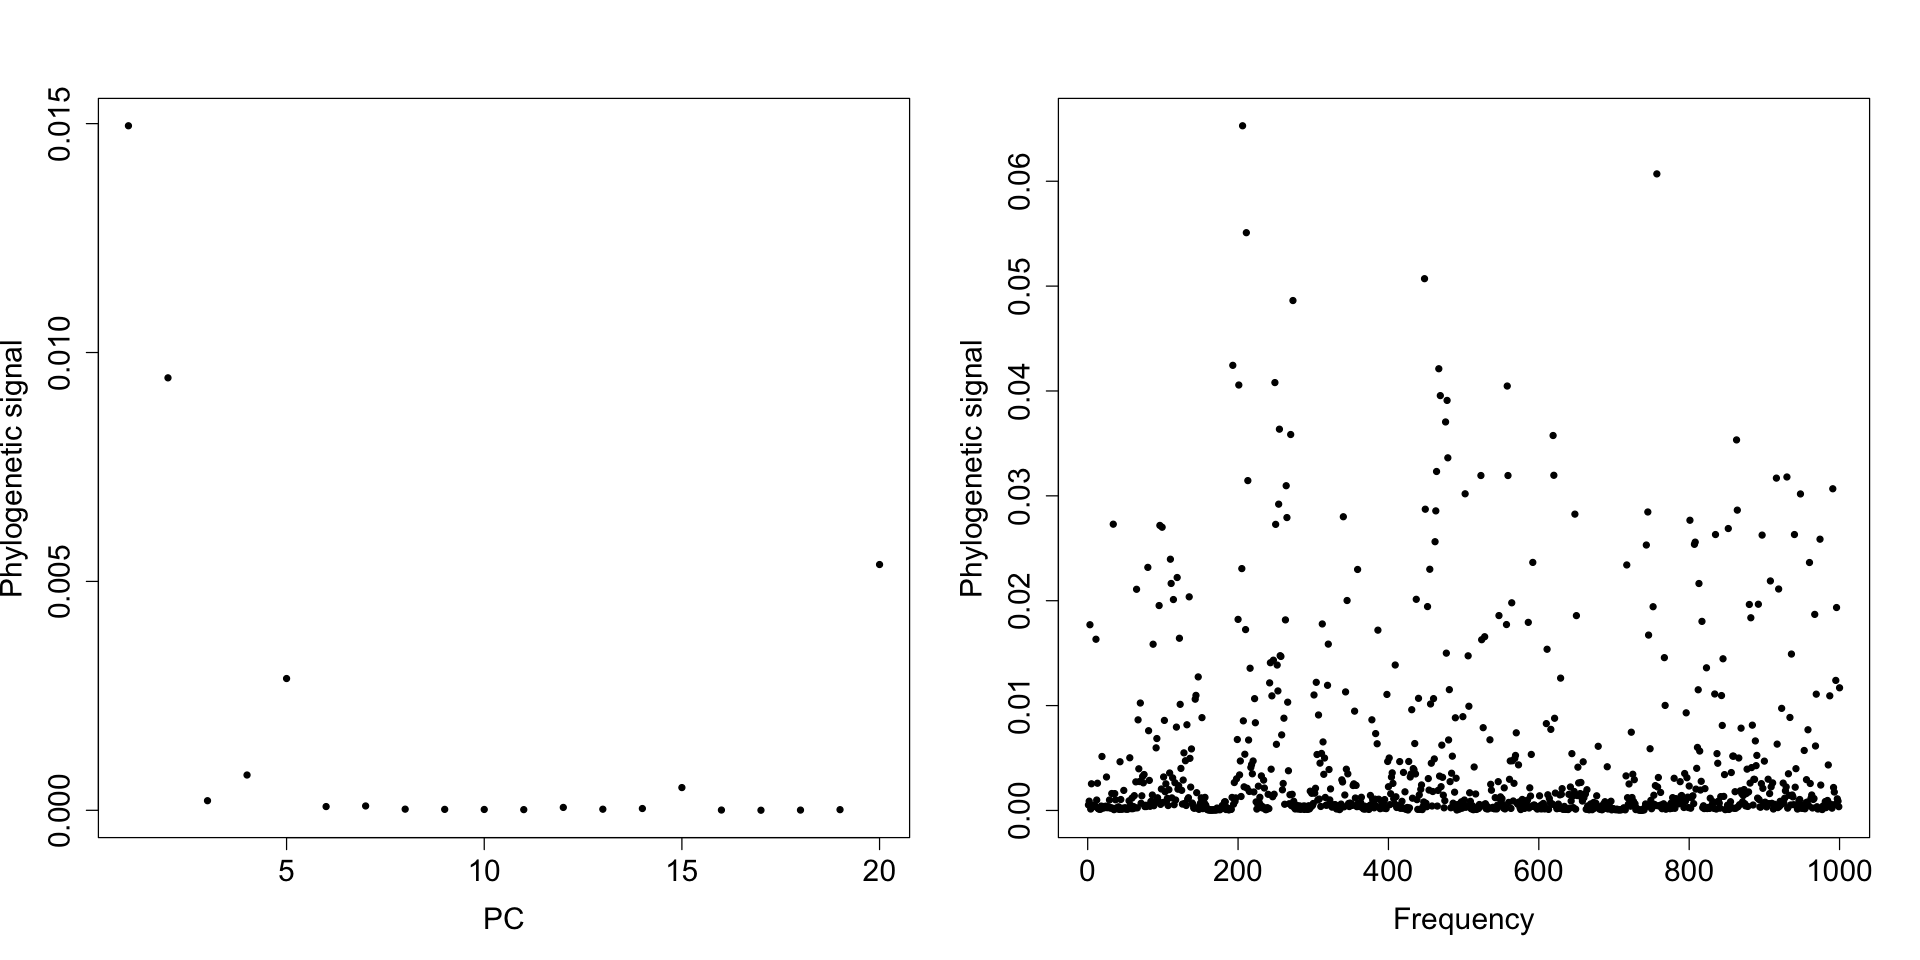

In [45]:
options(repr.plot.width=16, repr.plot.height=8)

par(mfrow = c(1,2))
plot(phylosig_pcs, pch = 20, cex.axis = 1.5, cex.lab = 1.5, xlab = 'PC', ylab = 'Phylogenetic signal')
plot(phylosig_spectra, pch = 20, cex.axis = 1.5, cex.lab = 1.5, xlab = 'Frequency', ylab = 'Phylogenetic signal')

## Overall correlation of taxonomy and spectral principal components

PCA on spectra

In [46]:
pca = prcomp(x)

Generate taxonomic matrix that matches length of sample matrix

In [48]:
pred = as.data.frame(cbind(apply(taxa, 2, function(x) rep(x, each = 100))))

Get all comparisons of pcs and predictors

In [49]:
toTest = expand.grid(1:50, 1:ncol(pred))

Generate linear models for all comparisons

In [51]:
#Run models
res = list()
for(i in 1:nrow(toTest)){
  res[[paste(toTest[i,1], toTest[i,2], sep = '_')]] = summary(lm(pca$x[,toTest[i,1]]~pred[,toTest[i,2]]))[[9]]
}
res = unlist(res)

#Split on pc
res = split(res, toTest[,1])

#Recombine
res = do.call(rbind, res)

Plot

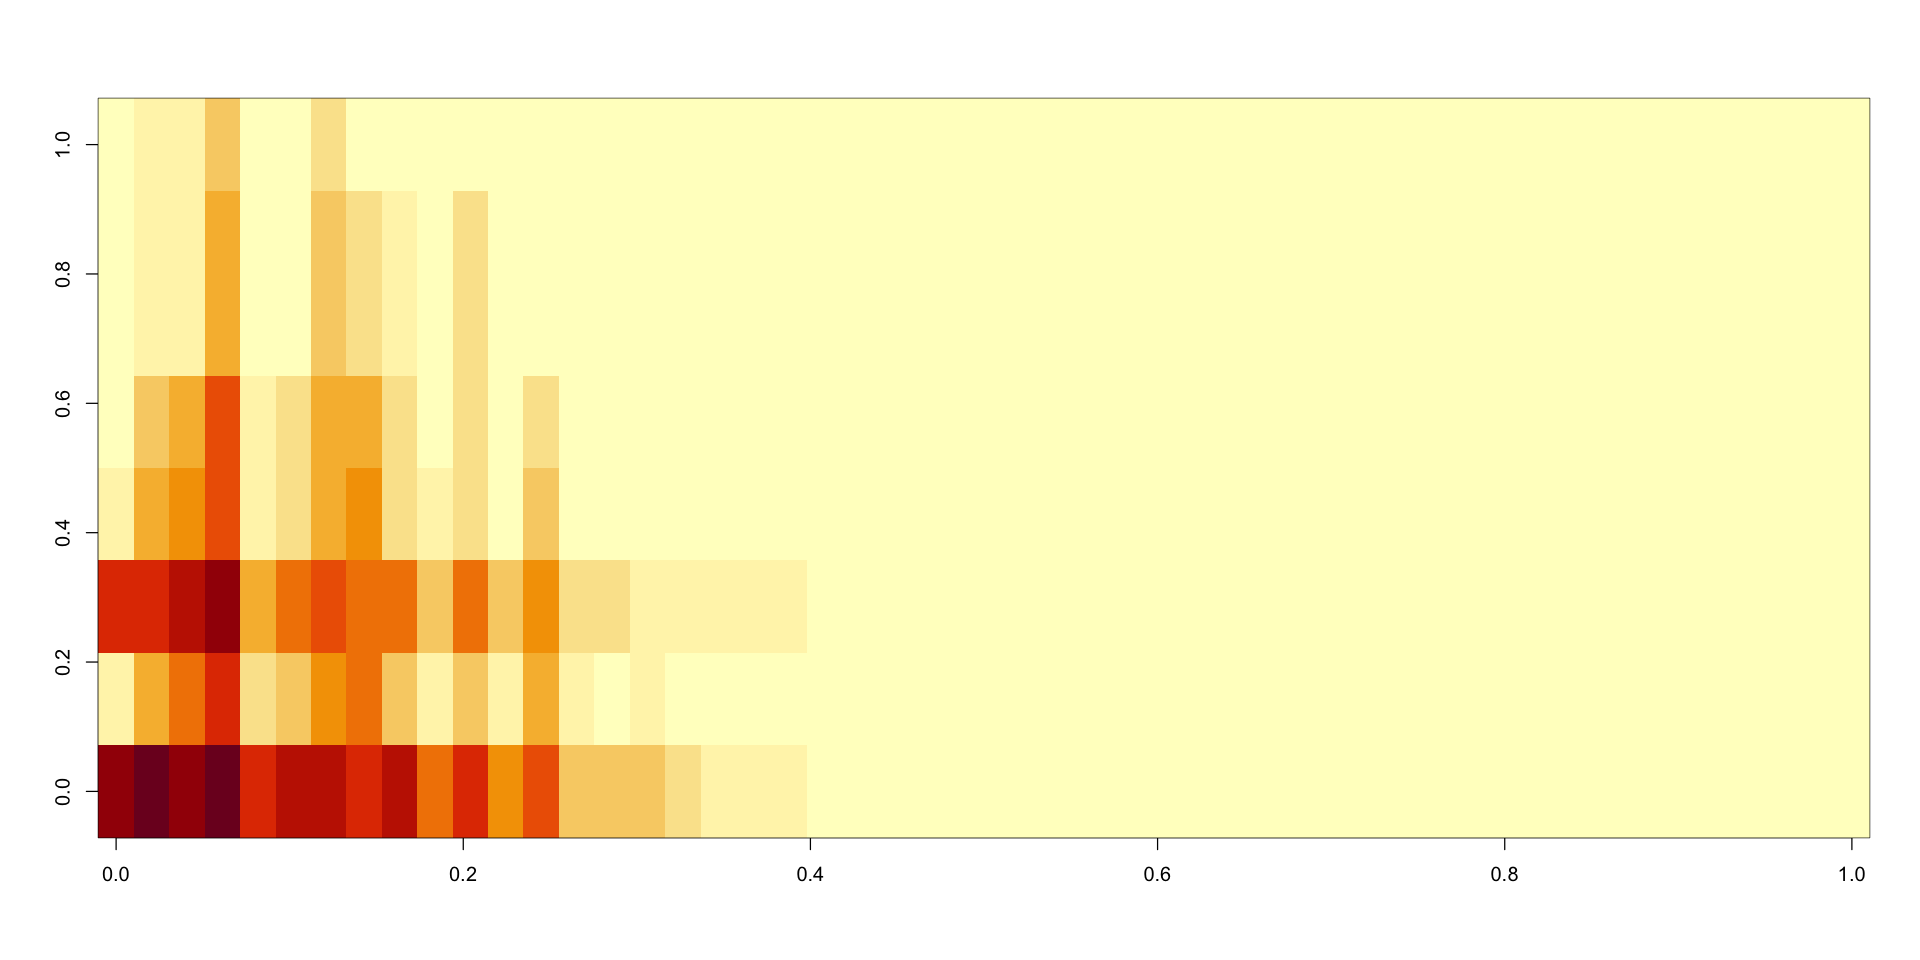

In [52]:
image(res)